<center>
    <span><h4><b>
        ROUTES RECOMENDATION </b></h4></span>

 </center>

#### In this notebook we will transform comments and we will try to create a recommendation system based on comments, route difficulty and its quality.

#### Load necessary tools and libraries

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('8a_kmeans')

In [4]:

import pyspark
import os
import math
import random
import sys

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

sc

In [5]:
from google.colab import drive
drive.mount('/content/drive')
import io 
import glob 
import pandas as pd

Mounted at /content/drive


In [13]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeansModel
from pyspark.ml.clustering import KMeans

#### Load data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DM_CLIMBING/all_unique_int.csv')

In [34]:
df['quality'] = df['quality'].fillna(0)

In [35]:
## Change types
df['quality'] = df['quality'].astype(int)
df['sector'] = df['sector'].astype(str)
df['region'] = df['region'].astype(str)

In [37]:
df = df[df['date'].notna()]

In [38]:
len(df.route.unique())

15152

In [39]:
df_spark = sc.createDataFrame(df)

In [40]:
df_spark.schema

StructType(List(StructField(Unnamed: 0,LongType,true),StructField(type,StringType,true),StructField(route,StringType,true),StructField(commentRich,StringType,true),StructField(quality,LongType,true),StructField(style,StringType,true),StructField(country,StringType,true),StructField(grade,DoubleType,true),StructField(Unnamed: 0.1,DoubleType,true),StructField(Unnamed: 0.1.1,DoubleType,true),StructField(Unnamed: 0.1.1.1,DoubleType,true),StructField(Unnamed: 0.1.1.1.1,DoubleType,true),StructField(crag,StringType,true),StructField(sector,StringType,true),StructField(date,StringType,true),StructField(region,StringType,true)))

#### Processing of comments to extract keywords and normalize

In [ ]:
# tokenization - braking sentence into single words

In [42]:
tokenizer = Tokenizer(inputCol="commentRich", outputCol="words")
wordsData = tokenizer.transform(df_spark)

In [43]:
wordsData.select('commentRich', 'words').show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|commentRich                                                                                                                                                            |words                                                                                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------

In [44]:
# stop words remover - that dont have meaning

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_nostop = remover.transform(wordsData)
df_nostop.show(truncate=False)

+----------+-------+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+--------+---------+-----+------------+--------------+----------------+------------------+-----------------------+--------------------+----------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Unnamed: 0|type   |route                       |commentRich                                                                                                                                                            |quality|style   |country  |grade|Unna

In [45]:
from nltk.stem.porter import *

In [46]:
#  Stemming of the tokenized corpus -  is a process of grouping together inflected forms of a word
stemmer = PorterStemmer()

In [69]:
pdf_nostop = df_nostop.toPandas()
pdf_nostop['words_stem'] = pdf_nostop.apply(lambda row: [stemmer.stem(token) for token in row['filtered']], axis=1)
pdf_nostop.head()

,Unnamed: 0,type,route,commentRich,quality,style,country,grade,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,crag,sector,date,region,words,filtered,words_stem
0,0,sport,Apache KId,"finally, with good conditions i managed to hol...",5,redpoint,andorra,8.05,1.0,1.0,60734.0,109775.0,B,nan,19/06/2011,nan,"[finally,, with, good, conditions, i, managed,...","[finally,, good, conditions, managed, hold, la...","[finally,, good, condit, manag, hold, last, ho..."
1,1,sport,Chunga Plus,# 2go,1,redpoint,argentina,8.05,10.0,10.0,169737.0,235917.0,Arenales,nan,10/01/2020,nan,"[#, 2go]","[#, 2go]","[#, 2go]"
2,2,sport,Puro bla bla,# 2go,1,redpoint,argentina,7.25,32.0,32.0,169779.0,236355.0,Valle encantado,nan,01/12/2005,nan,"[#, 2go]","[#, 2go]","[#, 2go]"
3,3,sport,Ergonomics,Amazing rock. The best 7b + I've tried,5,redpoint,australia,7.15,114.0,114.0,35045.0,54690.0,Unknown Crag,nan,10/07/2012,Arapiles,"[amazing, rock., the, best, 7b, +, i've, tried]","[amazing, rock., best, 7b, +, tried]","[amaz, rock., best, 7b, +, tri]"
4,4,sport,Sadomastication,# 2go Lowering off reigning steel. Tried the m...,5,redpoint,australia,7.15,247.0,247.0,228304.0,311072.0,Sublime Point,nan,05/08/2018,Blue Mountains,"[#, 2go, lowering, off, reigning, steel., trie...","[#, 2go, lowering, reigning, steel., tried, mo...","[#, 2go, lower, reign, steel., tri, move, firs..."


In [70]:
pdf_nostop['ID'] = pdf_nostop['Unnamed: 0']

In [71]:
pdf_nostop = pdf_nostop.drop('Unnamed: 0', axis = 1)

In [72]:
# use hashingTF to get term frequency
# convert to pyspark df:
pdf_nostop = sc.createDataFrame(pdf_nostop)
hashingTF = HashingTF(inputCol="words_stem", outputCol="comm_rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(pdf_nostop)

In [73]:
# inverse frequency IDF - is an Estimator which fits on a dataset and produces an IDFModel
idf = IDF(inputCol="comm_rawFeatures", outputCol="words_features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("route", "words_stem","words_features").show()

+--------------------+--------------------+--------------------+
|               route|          words_stem|      words_features|
+--------------------+--------------------+--------------------+
|          Apache KId|[finally,, good, ...|(20,[0,2,5,6,8,9,...|
|         Chunga Plus|            [#, 2go]|(20,[11,17],[0.72...|
|        Puro bla bla|            [#, 2go]|(20,[11,17],[0.72...|
|          Ergonomics|[amaz, rock., bes...|(20,[0,3,4,14,15,...|
|     Sadomastication|[#, 2go, lower, r...|(20,[0,1,2,3,4,5,...|
|          Wiggly Boy|           [wiggle?]|(20,[11],[0.72375...|
|            2nd Skin|[deep, start,, fo...|(20,[0,2,4,5,7,15...|
|30 Terrabite BlÃ...|[rope., first, tr...|(20,[0,3,7,19],[1...|
|            5 Sterne|[5, \., attempt.,...|(20,[1,3,6,7,12,1...|
|    A flotter Dreier|            [#, 2go]|(20,[11,17],[0.72...|
|     AbsÃÂÃÂ¤tzle|[yippieii, great,...|(20,[0,1,6,10,12,...|
|          Adabsurdum|[well, psychee, !...|(20,[13,17,18],[1...|
|           Akku leer|[#,

In [74]:
# normalize the feature vector
normalizer = Normalizer(inputCol="words_features", outputCol="words_norm")
normalizedData = normalizer.transform(rescaledData)

normalizedData.select("type","route", "grade", "crag","region", "country", "quality","words_norm").show()

+-------+--------------------+-----+--------------------+--------------+---------+-------+--------------------+
|   type|               route|grade|                crag|        region|  country|quality|          words_norm|
+-------+--------------------+-----+--------------------+--------------+---------+-------+--------------------+
|  sport|          Apache KId| 8.05|                   B|           nan|  andorra|      5|(20,[0,2,5,6,8,9,...|
|  sport|         Chunga Plus| 8.05|            Arenales|           nan|argentina|      1|(20,[11,17],[0.73...|
|  sport|        Puro bla bla| 7.25|     Valle encantado|           nan|argentina|      1|(20,[11,17],[0.73...|
|  sport|          Ergonomics| 7.15|        Unknown Crag|      Arapiles|australia|      5|(20,[0,3,4,14,15,...|
|  sport|     Sadomastication| 7.15|       Sublime Point|Blue Mountains|australia|      5|(20,[0,1,2,3,4,5,...|
|boulder|          Wiggly Boy|  6.0|           Trackside|     Grampians|australia|      1|     (20,[11],

In [75]:
normalizedData.cache()

DataFrame[type: string, route: string, commentRich: string, quality: bigint, style: string, country: string, grade: double, Unnamed: 0.1: double, Unnamed: 0.1.1: double, Unnamed: 0.1.1.1: double, Unnamed: 0.1.1.1.1: double, crag: string, sector: string, date: string, region: string, words: array<string>, filtered: array<string>, words_stem: array<string>, ID: bigint, comm_rawFeatures: vector, words_features: vector, words_norm: vector]

####K-means aproach

As with the region recommendation based on user profile, we now also use the approach of finding similar routes using clusterisation.

In [76]:
features_names = ["grade", "quality","words_norm"]

In [78]:
vecAssembler = VectorAssembler(inputCols=features_names, outputCol="features")
df_kmeans = vecAssembler.transform(normalizedData).select("ID", "features")

In [81]:
## find best k
cost = np.zeros(100)
for k in range(2,100):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans.select('features'))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

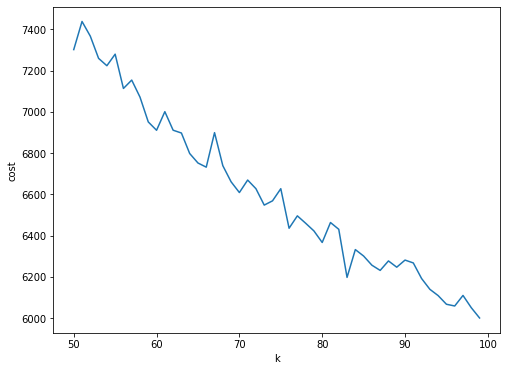

In [83]:
## plot cost for each k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(50,100),cost[50:100])
ax.set_xlabel('k')
ax.set_ylabel('cost')

A clear decline can be seen in this range, so we decided to look for a wider range of clusters.

In [86]:
## find best k
cost = np.zeros(200)
for k in range(2,200):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans.select('features'))
    cost[k] = model.summary.trainingCost

Check if bigger amunt of clusters gives less cost:

Text(0, 0.5, 'cost')

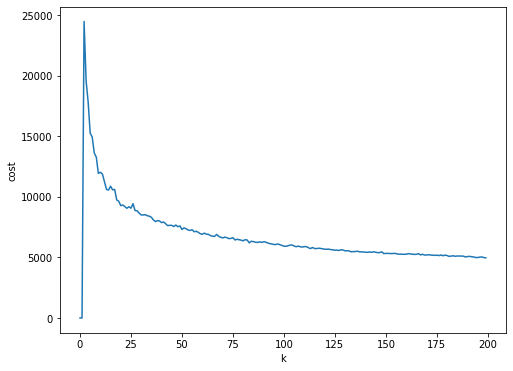

In [87]:
## plot cost for each k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(0,200),cost[0:200])
ax.set_xlabel('k')
ax.set_ylabel('cost')

However, after checking for k from 0 to 200, we can see that the decline slows down around 50 and smoothes out from around 75

In [ ]:
## make k-means clustering model with k based on previous calculations
## in that case we chosed k = 75 
k = 75
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
## fit the model to all data
model2 = kmeans.fit(df_kmeans)
centers = model2.clusterCenters()

model2.save("/content/drive/MyDrive/DM_CLIMBING/kmeans_routes")

print("Cluster Centers: ")
for center in centers:
    print(center)

In [89]:
transformed = model2.transform(df_kmeans).select('ID', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(ID=0, prediction=11), Row(ID=1, prediction=13), Row(ID=2, prediction=5)]


In [91]:
df_pred = sc.createDataFrame(rows)
df_pred.show()

+---+----------+
| ID|prediction|
+---+----------+
|  0|        11|
|  1|        13|
|  2|         5|
|  3|        43|
|  4|        59|
|  5|        29|
|  6|         2|
|  7|        41|
|  8|        35|
|  9|         5|
| 10|        10|
| 11|         6|
| 12|         7|
| 13|        51|
| 14|        46|
| 15|        54|
| 16|         7|
| 17|        10|
| 18|        32|
| 19|        67|
+---+----------+
only showing top 20 rows



In [ ]:
## join predictions with all data frame
df_pred = df_pred.join(normalizedData, 'ID')
df_pred.show()
pddf_pred = df_pred.toPandas().set_index('ID')


In [93]:
pddf_pred.to_csv(('/content/drive/MyDrive/DM_CLIMBING/routes_predicted.csv'))

#### Routes recomendation

In [144]:
def recomend_routes (fav_routes, max_grade, min_grade, nr_recomend, main_df):
  clusters_list = []

  for route in fav_routes:
    ## check in which cluster is each route from list of favorities
    nbr = main_df['prediction'][main_df['route']==route].values[0]
    clusters_list.append(nbr)

  ## take only that rows which are in selected clusters
  rec_df = main_df.loc[main_df['prediction'].isin(clusters_list)]
  ## filter data by grade range provided by user
  rec_df = rec_df.loc[(rec_df['grade']>= min_grade) & (rec_df['grade'] <= max_grade)]
  ## sort recomended routes by quality
  rec_df = rec_df.sort_values(by = 'quality', ascending=False)
  ## take n routes from the top - with best quality
  rec_df =  rec_df.head(nr_recomend)
  return rec_df




Example prediction:
User provide list of favorite routes, max grade that would climb and min grade, also has to write how many routes system should recomend

In [151]:
fav_routes = ['Ergonomics', 'Sadomastication']
max_grade = 8.00
min_grade = 6.00
nr_recomend = 20

In [152]:
## get recomended routes:
df_recomended = recomend_routes(fav_routes, max_grade, min_grade, nr_recomend,pddf_pred )

[43]
[43, 59]


In [153]:
## show recomended routes and dropp useless columns
df_recomended.drop(['style', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'date', 'words', 'filtered', 'words_stem', 'comm_rawFeatures', 'words_features', 'words_norm'], axis = 1)

,prediction,type,route,commentRich,quality,country,grade,crag,sector,region
ID,,,,,,,,,,
15437,43,sport,Scavenger,"# 2go Blew the OS immediately, lowered and sen...",5,united states,7.20,Mill Creek,wicked crag,nan
13488,43,sport,Colpo Grosso,"#FA Wuhuuu ... first routes we put with Seb, A...",5,turkey,7.25,DatÃÂÃÂ§a,cyclope,nan
4,59,sport,Sadomastication,# 2go Lowering off reigning steel. Tried the m...,5,australia,7.15,Sublime Point,nan,Blue Mountains
15613,43,sport,Squeezing My Will to Live,"4th go of the day, B sent right after 5th go",5,united states,7.25,Unknown Crag,nan,Clear Creek Canyon (CO)
5789,59,sport,Phnom Phen,Hold historic plaque style!,5,italy,7.25,MUZZERONE,parete centrale,Genua
2330,43,sport,Les colonnettes,# 2go 1st go this year!,5,france,7.25,CÃÂÃÂ©ÃÂÃÂ¼se,biographie 8faa4,Provence
15581,43,sport,Space X full,"11b to the first anchors, 12c to the top. exce...",5,united states,7.15,Lime Kiln Canyon,nan,nan
2467,59,sport,Mecanik destruktiv komando,Polish footholds but great long moves ),5,france,7.20,Gorges du Loup,deverse,Nice
10357,43,sport,Kaplan,PC. (L1). In the morning in the parking lot Lo...,5,spain,7.00,Chulilla,canaveral,nan
